In [1]:
import warnings
warnings.filterwarnings("ignore")
from timeit import default_timer as timer

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dense, Dropout, BatchNormalization
from keras.losses import categorical_crossentropy

In [3]:
print('Num GPUs Available: ', len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  2


In [4]:
train_path = r'/kaggle/input/dataset/train'

In [11]:
test_path = r'/kaggle/input/real-data'

In [7]:
val_path = r'/kaggle/input/dataset/val'

In [8]:
image_size = (150, 150) 

batch_size = 32

In [9]:
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

train_generator = train_datagen.flow_from_directory(train_path,
                                                    target_size=image_size,
                                                    batch_size=batch_size,
                                                    class_mode='categorical',
                                                    shuffle=True)

Found 4946 images belonging to 2 classes.


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)


test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 108 images belonging to 1 classes.


In [13]:
val_datagen = ImageDataGenerator(rescale=1./255)


validation_generator = val_datagen.flow_from_directory(
        val_path,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True)

Found 120 images belonging to 2 classes.


In [14]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label in in train and validation datasets\n")

for key, value in labels.items():
    print(f'{key} : {value}')

Label in in train and validation datasets

0 : Normal
1 : OSCC


In [15]:
model = Sequential()

In [16]:
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(150, 150, 3)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

model.add(Flatten())

model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Dense(2, activation='softmax'))

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 150, 150, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 64)        18496     
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 64)        2

In [18]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience = 3, min_lr =1e-6, verbose=1)

In [20]:
with tf.device('/GPU:0'):
    start = timer()
    history = model.fit(train_generator, validation_data = validation_generator, batch_size = 32, epochs = 30, verbose = 1)
    end = timer()

Epoch 1/30


2024-08-24 14:00:07.616265: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


155/155 [==============================] - 127s 777ms/step - loss: 0.7271 - accuracy: 0.6684 - val_loss: 4.4948 - val_accuracy: 0.2333
Epoch 2/30
155/155 [==============================] - 79s 508ms/step - loss: 0.5094 - accuracy: 0.7566 - val_loss: 0.5718 - val_accuracy: 0.7667
Epoch 3/30
155/155 [==============================] - 78s 500ms/step - loss: 0.4607 - accuracy: 0.7893 - val_loss: 0.4871 - val_accuracy: 0.7750
Epoch 4/30
155/155 [==============================] - 77s 500ms/step - loss: 0.4153 - accuracy: 0.8093 - val_loss: 0.5941 - val_accuracy: 0.7417
Epoch 5/30
155/155 [==============================] - 77s 500ms/step - loss: 0.3919 - accuracy: 0.8229 - val_loss: 1.2721 - val_accuracy: 0.7667
Epoch 6/30
155/155 [==============================] - 78s 500ms/step - loss: 0.3700 - accuracy: 0.8326 - val_loss: 1.2772 - val_accuracy: 0.7333
Epoch 7/30
155/155 [==============================] - 77s 499ms/step - loss: 0.4077 - accuracy: 0.8146 - val_loss: 0.6706 - val_accuracy: 0.

In [21]:
result = model.evaluate(test_generator)

4/4 [==============================] - 4s 1s/step - loss: 18.8488 - accuracy: 0.0185


In [23]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Loss')

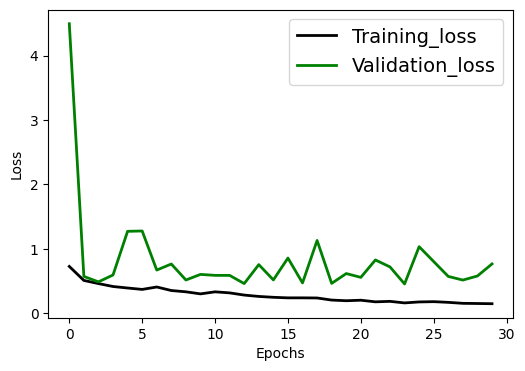

In [24]:
plt.figure(figsize=[6, 4])
plt.plot(history.history['loss'], 'black', linewidth=2.0)
plt.plot(history.history['val_loss'], 'green', linewidth=2.0)
plt.legend(['Training_loss', 'Validation_loss'],fontsize=14)
plt.xlabel('Epochs', fontsize=10)
plt.ylabel('Loss', fontsize=10)

In [25]:
test_predictions = model.predict(validation_generator)
test_predictions_classes = np.where(test_predictions > 0.5, 1, 0)

4/4 [==============================] - 6s 1s/step


In [26]:
print("GPU time: ", end - start)

GPU time:  2390.619147114
